In [1]:
import pandas as pd
import numpy as np
import glob
import json
import re
import pickle
# import text analysis libraries
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import textstat
import string
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Pretty Graphing
import pandas as pd

import bebi103

import altair as alt
import altair_catplot as altcat
import bokeh.plotting
import bokeh.io

bokeh.io.output_notebook()

/Users/lisazhu/anaconda3/lib/python3.6/site-packages/bebi103/viz.py:30: UserWarning: DataShader import failed with error "No module named 'datashader'".
Features requiring DataShader will not work and you will get exceptions.
  Features requiring DataShader will not work and you will get exceptions.""")


Loading BokehJS ...

# Preliminary Analysis of Comments


This notebook was used to analyze the metrics we looked at in our paper. For help installing necessary packages such as Bokeh, altair, etc., see http://bebi103.caltech.edu.s3-website-us-east-1.amazonaws.com/2018/tutorials/t0a_python_for_scientific_computing.html (a BE/Bi103 Tutorial on setting up Jupyter Lab and Anaconda to work with these packages)


### Reading in all the comments

We first ran getCommentThreads.py to get all the comments for all our submissions. Comments for election data was stored in a directory called `comments`, and other data in a directory called `nonpolitical`.

In [16]:
# Grab all the .json files
# change 'nonpolitical/*.json' to 'comments/*.json' for just the election data.
commentFiles = glob.glob('nonpolitical/*.json', recursive=True)

Let's check how many files of comments we have.

In [4]:
len(commentFiles)

267

We will now create a giant dictionary where the keys that map submission IDs to all the comments in a submission.

In [17]:
# Put all the information into a massive dictionary, indexed by submission ID
commentDict = {}
for f in commentFiles:
    with open(f) as json_file:  
        commentDict[f[-11:-5]] = json.load(json_file)["data"]
    

# Calculating Metrics


Next, we're going to iterate through all the comments, figure out which ones got deltas and which ones didn't, and calculate the reading levels of each as well as analyze the sentiment for all these comments.

This is a basically a bunch of nested `for` loops. It's not pretty, but it works. It takes ~5 minutes to run on comments from ~260 submissions.

In [57]:
# Create a dict per submission of good authors
deltaAuthors = {}

# lists of Flesch Reading Ease scores
complexityDeltaPosts = []
complexityOtherPosts = []

# Sentiment: a list of lists in the form [composite score, pos, neutral, negative]
avgSentimentDeltaPosts = []
avgSentimentOtherPosts = []

# Lists of lists in form of [score, gilded, controversiality] where gilded + controversiality are 0/1
scoreDeltaPosts = []
scoreOtherPosts = []


# Length data: lists of lists in the form of [avg sentence length, total word count]
lengthDeltaPosts = []
lengthOtherPosts = []

# get all usernames, ids, and delta comments
deltaComments = []
otherComments = []

i = 0
for key, jsonData in commentDict.items():
    # Print out iterations 
    if i % 10 == 0:
        print(i)
    deltaAuthors[key] = []
    for x in range(len(jsonData)):
        # Mine the deltabot comment to find the users who write the good comments
        if (jsonData[x]["author"] == "DeltaBot" and 
                        "awarded" in jsonData[x]["body"]):
                text = jsonData[x]["body"]
                m = re.search('(.*)/u/(.*?) (.*)', text)
                try: 
                    deltaAuthors[key].append(m.group(2)[:-1])
                except AttributeError: 
                    continue
        
    # iterate through the comment thread a 2nd time to add the numeral info to our lists
    for x in range(len(jsonData)):
        text = jsonData[x]["body"]
        newlineFree = text.replace("\n", " ")
        
        # remove all URLs
        urlFree = re.sub(r"http\S+", "", newlineFree)
        # Need to evaluate each comment for complexity
        complexity = textstat.flesch_kincaid_grade(newlineFree)

        # Next, we have to use nltk to break the paragraphs into sentences for VADER
        # and evaluate sentiment for each sentence in the comment before averaging
        # Note: positive sentiment: compound score >= 0.05
        # neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
        # negative sentiment: compound score <= -0.05
        sentence_list = tokenize.sent_tokenize(newlineFree)
        parScore = 0.0
        posScore = 0.0
        negScore = 0.0
        neuScore = 0.0
    
        avgLength = 0
        totalLength = 0
        analyzer = SentimentIntensityAnalyzer()
        for sentence in sentence_list:
            # calculate sentence lengths by splitting each 
            totalLength += len(sentence.split(" "))
            vs = analyzer.polarity_scores(sentence)
            parScore += vs["compound"]
            posScore += vs["pos"]
            negScore += vs["neg"]
            neuScore += vs["neu"]

            
        avgSentiment = [parScore / len(sentence_list), posScore / len(sentence_list),
                        neuScore / len(sentence_list), negScore / len(sentence_list)]

        avgLength = totalLength / len(sentence_list)
        

        
        # Last but not least, we need to grab the upvotes, gilded status, controversiality
        try: 
            currPostInfo = [jsonData[x]["score"], jsonData[x]["gilded"], 
                            jsonData[x]["controversiality"]]
        except KeyError:
            continue

        # add the data to the correct lists
        if (jsonData[x]["author"] in deltaAuthors[key]):
            complexityDeltaPosts.append(complexity)
            avgSentimentDeltaPosts.append(avgSentiment)
            scoreDeltaPosts.append(currPostInfo)
            lengthDeltaPosts.append([avgLength, totalLength])
            if len(urlFree.split()) >= 5:
                deltaComments.append([key, jsonData[x]["author"], urlFree, "delta"])
            
        else:
            complexityOtherPosts.append(complexity)
            avgSentimentOtherPosts.append(avgSentiment)
            scoreOtherPosts.append(currPostInfo)
            lengthOtherPosts.append([avgLength, totalLength, 0])
            otherComments.append([key, jsonData[x]["author"], urlFree, "none"])
    
    
    i += 1


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240


For future use, we saved dataframes with comment data to files.

In [15]:
df = pd.DataFrame(deltaComments, columns=["id", "author", "selftext", "deltaBool"])
df.to_csv("delta_comments.csv", index=False)
df = pd.DataFrame(otherComments, columns=["id", "author", "selftext", "deltaBool"])
df.to_csv("other_comments.csv", index=False)

# Graphs


In [59]:
def plot_boxplots(deltaData, otherData, title):
    deltaData = np.array(deltaData)
    otherData = np.array(otherData)
    plt.rcParams['figure.figsize'] = [10, 5]
    dataDict = {"delta" : deltaData, "other" : otherData}
    fig, ax = plt.subplots()
    ax.boxplot(dataDict.values(), vert=False, showmeans=True)
    # ax.set_yticklabels(dataDict.keys())
    ax.set_yticklabels(["Delta Receiving Comments", "Non-Delta Receiving Comments"])
    ax.set_xlabel(title)

    plt.axvline(x=np.mean(deltaData), c='red', label='Mean of Delta Receiving Comments')
    plt.axvline(x=np.mean(otherData),  c='blue',label='Mean of Other Comments')
    plt.legend()

### Flesch Reading Ease

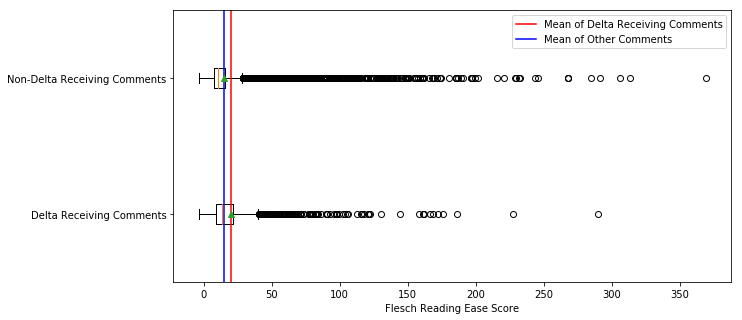

In [58]:
plot_boxplots(np.array(complexityDeltaPosts , complexityOtherPosts)[:,0], "Flesch Reading Ease Score")

## Comment Score

In [10]:
# histogram for informational purposes only
p = bebi103.viz.histogram(data=scoreDeltaPosts, 
                          kind='step_filled', 
                          fill_alpha=0.5, bins=100, density=False)
bokeh.io.show(p)

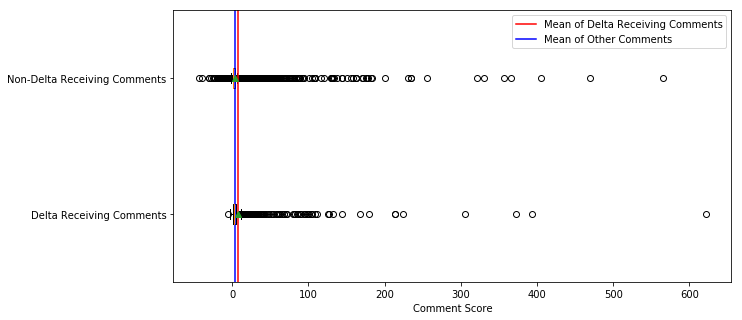

In [60]:
plot_boxplots(np.array(scoreDeltaPosts)[:,0], np.array(scoreOtherPosts)[:,0], "Comment Score")

In [61]:
print(np.std(np.array(scoreDeltaPosts)[:,0]))
print(np.std(np.array(scoreOtherPosts)[:,0]))

28.721438230707417
12.042383366284053


## Sentiment

In [62]:
avgSentimentDeltaPosts = np.array(avgSentimentDeltaPosts)
avgSentimentOtherPosts = np.array(avgSentimentOtherPosts)


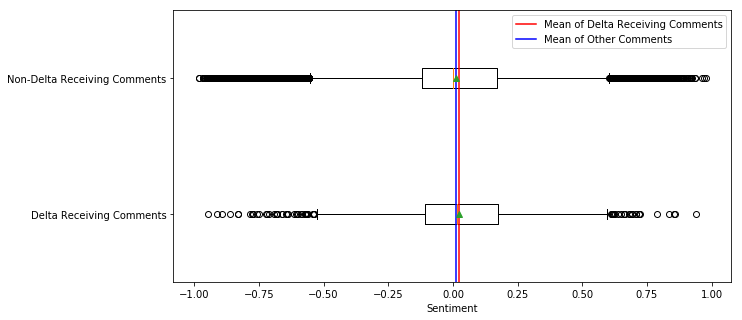

In [63]:
plot_boxplots(avgSentimentDeltaPosts[:,0], avgSentimentOtherPosts[:,0], "Sentiment")

In [64]:
print(np.mean(avgSentimentDeltaPosts[:,0]))
print(np.mean(avgSentimentOtherPosts[:,0]))

0.02424678206083488
0.011987670312967375


## Histograms for Flesch Reading Ease

These were not used in our final paper...these are kinda out of order too, sorry about that.

In [65]:
complexity = np.array(complexityDeltaPosts)
p = bebi103.viz.histogram(data=complexity, 
                          kind='step_filled', 
                          fill_alpha=0.5, bins=100, density=False,
                         x_axis_label="Flesch Reading Ease of Delta-Receiving Comments",
                         y_axis_label='Frequency')
bokeh.io.show(p)
print(np.mean(complexity))

19.995750332005315


In [66]:
complexity = np.array(complexityOtherPosts)
p = bebi103.viz.histogram(data=complexity, 
                          kind='step_filled', 
                          fill_alpha=0.5, bins=100, density=False,
                         x_axis_label="Flesch Reading Ease of non-Delta-Receiving Comments",
                         y_axis_label='Frequency',
                          )
bokeh.io.show(p)
print(np.mean(complexity))

15.336638080602786


## Length of sentences and Comments



### Avg Sentence Length

In [67]:
length = np.array(lengthDeltaPosts)
p = bebi103.viz.histogram(data=length[:,0], 
                          kind='step_filled', 
                          fill_alpha=0.5, bins=100, density=False,
                         x_axis_label="Average Sentence Length of Delta-Receiving Comments",
                         y_axis_label='Frequency',
                          )
bokeh.io.show(p)
print(np.mean(length[:,0]))
print(np.std(length[:,0]))

18.180209898344938
8.931729182791221


In [68]:
lengthOtherPosts = np.array(lengthOtherPosts)
p = bebi103.viz.histogram(data=lengthOtherPosts[:,0], 
                          kind='step_filled', 
                          fill_alpha=0.5, bins=100, density=False,
                         x_axis_label="Average Sentence Length of non-Delta-Receiving Comments",
                         y_axis_label='Frequency',
                          )
bokeh.io.show(p)
print(np.mean(lengthOtherPosts[:,0]))
print(np.std(lengthOtherPosts[:,0]))

15.52990713389112
9.138519720748132


### Comment Length

In [69]:
lengthDeltaPosts = np.array(lengthDeltaPosts)
p = bebi103.viz.histogram(data=lengthDeltaPosts[:,1], 
                          kind='step_filled', 
                          fill_alpha=0.5, bins=100, density=False,
                         x_axis_label="Length of Delta-Receiving Comments (words)",
                         y_axis_label='Frequency',
                          )
bokeh.io.show(p)
print(np.mean(lengthDeltaPosts[:,1]))
print(np.std(lengthDeltaPosts[:,1]))

158.2164674634794
204.05878809404646


In [70]:
lengthOtherPosts = np.array(lengthOtherPosts)
p = bebi103.viz.histogram(data=length[:,1], 
                          kind='step_filled', 
                          fill_alpha=0.5, bins=100, density=False,
                         x_axis_label="Comment Length of non-Delta-Receiving Comments (words)",
                         y_axis_label='Frequency',
                          )
bokeh.io.show(p)
print(np.mean(lengthOtherPosts[:,1]))
print(np.std(lengthOtherPosts[:,1]))

85.66098250136321
118.37773766659868


# General overview histograms for all the data

In [18]:
deltaCommentCounts = [0] * len(commentDict.items())
otherCommentCounts = [0] * len(commentDict.items())

i = 0
for key, jsonData in commentDict.items():
    # Print out iterations 
    if i % 10 == 0:
        print(i)
    for x in range(len(jsonData)):
        # Mine the deltabot comment to find the users who write the good comments
        if (jsonData[x]["author"] == "DeltaBot" and 
                        "awarded" in jsonData[x]["body"]):
            deltaCommentCounts[i] += 1
        else:
            otherCommentCounts[i] += 1
    i += 1

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240


1.7620967741935485
1.2361551174936436


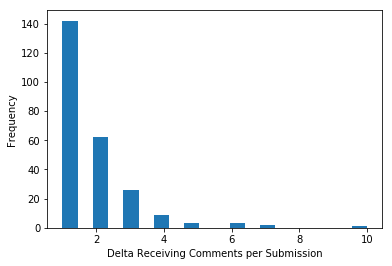

In [19]:
fig, ax = plt.subplots()
plt.hist(deltaCommentCounts, bins=20)
ax.set_xlabel("Delta Receiving Comments per Submission")
ax.set_ylabel("Frequency")
# plt.axvline(np.mean(deltaCommentCounts), color='k', linestyle='dashed', linewidth=1)
print(np.mean(deltaCommentCounts))
print(np.std(deltaCommentCounts))

Below, we're just calculating the total number of delta and other comments in our dataset.

In [22]:
sum(deltaCommentCounts)

437

In [23]:
sum(otherCommentCounts)

21242

Let's plot out the non-delta receiving comments in our data.

85.65322580645162
118.12343491742419


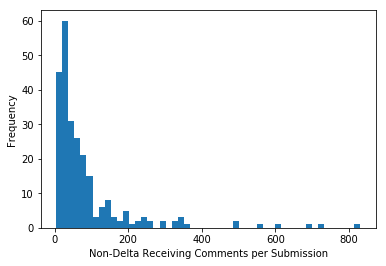

In [21]:
fig, ax = plt.subplots()
plt.hist(otherCommentCounts, bins=50)
ax.set_xlabel("Non-Delta Receiving Comments per Submission")
ax.set_ylabel("Frequency")
# plt.axvline(np.mean(otherCommentCounts), color='k', linestyle='dashed', linewidth=1)
print(np.mean(otherCommentCounts))
print(np.std(otherCommentCounts))

# Hypothesis Testing 

In [28]:
# bootstrapping functions

def draw_bs_sample(data):
    """
    Draw a bootstrap sample from a 1D data set.
    """
    return np.random.choice(data, size=len(data))



def draw_bs_reps_mean(data, size=10000):
    """
    Draw boostrap replicates of the mean from 1D data set.
    """
    out = np.empty(size)
    for i in range(size):
        out[i] = np.mean(draw_bs_sample(data))
    return out


def draw_bs_reps_diff_mean(x, y, size=10000):
    """
    Generate bootstrap replicates with difference of means
    as the test statistic.
    """
    out = np.empty(size)
    for i in range(size):
        out[i] = np.mean(draw_bs_sample(x)) - np.mean(draw_bs_sample(y))
    return out


In [76]:
# Testing whether mean(x) > mean(y)
def getPVal(x, y, size=100000):
    bs_reps = draw_bs_reps_diff_mean(x, y, size=100000)

    diff_mean =  np.mean(x) - np.mean(y)

    p_val = np.sum(bs_reps < 0) / len(bs_reps)

    print('p-value =', p_val)
    return p_val

Note: Because we drew 100000 samples per hypothesis test, a p-value of 0 from our tests means that our p-value is under 1e-5.

## Bootstrap: delta comment score > other comment



In [77]:
getPVal(np.array(scoreDeltaPosts)[:,0], np.array(scoreOtherPosts)[:,0])

p-value = 0.0


0.0

## Bootstrap: Sentiment

In [72]:
getPVal(np.array(avgSentimentDeltaPosts)[:,0], np.array(avgSentimentOtherPosts)[:,0])

p-value = 0.03819


0.03819

# Boostrap: Flesch

In [73]:
getPVal(complexityDeltaPosts, complexityOtherPosts)

p-value = 0.0


0.0

# Bootstrap: Sentence Length

In [74]:
getPVal(lengthDeltaPosts[:,0], lengthOtherPosts[:,0])

p-value = 0.0


0.0

# Boostrap: comment Length

In [75]:
getPVal(lengthDeltaPosts[:,1], lengthOtherPosts[:,1])

p-value = 0.0


0.0